<a href="https://colab.research.google.com/github/karaimer/Camera-Pipeline-Python/blob/master/SimplifiedCameraPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simplified example for an in-camera imaging pipeline

In [0]:
!pip install rawpy

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

Include rawpy which is based on LibRaw Library which is based on dcraw 

In [0]:
import rawpy
import PIL
import numpy as np

Below to read the image file from your Google Drive. You need to do it for yourself. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!wget  -O '/content/drive/My Drive/RAW_NIKON_D3.NEF' "http://www.rawsamples.ch/raws/nikon/d3/RAW_NIKON_D3.NEF"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2020-02-15 16:14:02--  http://www.rawsamples.ch/raws/nikon/d3/RAW_NIKON_D3.NEF
Resolving www.rawsamples.ch (www.rawsamples.ch)... 149.126.4.60, 2a01:ab20:0:4::60
Connecting to www.rawsamples.ch (www.rawsamples.ch)|149.126.4.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26088864 (25M) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/RAW_NIKON_D3.NEF’

/content/drive/My D 100%[===================>]  24.88M  4.72MB/s    in 6.0s    

2020-02-15 16:14:08 (4.16 MB/s) - ‘/content/drive/My Drive/RAW_NIKON_D3.NEF’ saved [26088864/26088864]



Step 0: Reading the raw image 

Image at this stage is in the mosaiced Bayer pattern format.

In [0]:
raw = rawpy.imread('/content/drive/My Drive/RAW_NIKON_D3.NEF')

Below is how we access the mosaiced raw image using this API.   

Text(0.5, 1.0, 'This is the raw image')

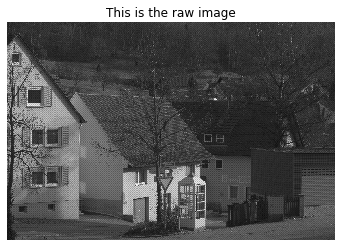

In [0]:
mosaic = raw.raw_image
img_visualize = np.float32(mosaic) / 2**16
plt.imshow(img_visualize**(1/2.2), cmap='gray')
plt.axis('off')
plt.title('This is the raw image')

In [0]:
black = mosaic.min()#proc.imgdata.color.black
#print(black)

In [0]:
saturation = mosaic.max()#proc.imgdata.color.black
#print(saturation)

In [0]:
#print(mosaic.dtype)

Step 1: Linearization

Text(0.5, 1.0, 'The image is now linearized')

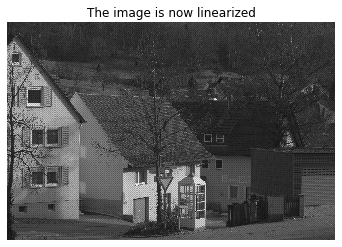

In [0]:
black = mosaic.min()#proc.imgdata.color.black
saturation = mosaic.max()

uint14_max = 2**14 - 1
mosaic -= black                    # black subtraction
mosaic *= int(uint14_max/(saturation - black))
mosaic = np.clip(mosaic,0,uint14_max)  # clip to range
#print(mosaic.max())

mosaic = np.float64(mosaic) 
#print(mosaic.max())

#print(raw.black_level_per_channel)
#print('color_matrix:', raw.color_matrix)
#print('rgb_xyz_matrix:', raw.rgb_xyz_matrix)
#print('tone_curve:', raw.tone_curve)

img_visualize = np.float32(mosaic) / 2**14
plt.imshow(img_visualize**(1/2.2), cmap='gray')
plt.axis('off')
plt.title('The image is now linearized')

Step 2: White Balancing 

Here we use the parameters that are captured during imaging to render the image. You can replace the following to apply your own whitebalance.  

In [0]:
cam_mul = np.asarray(raw.camera_whitebalance)
# Above we use the white balance values captured by the camera.

Text(0.5, 1.0, 'The image is now whitebalanced')

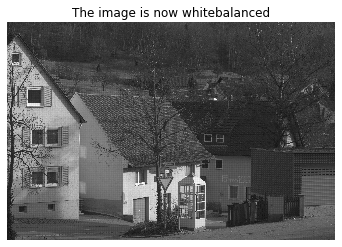

In [0]:
# the followinng is an alternative wb 
#cam_mul = np.asarray(raw.daylight_whitebalance)

# another alternative is the Gray World algorithm
def gray_world(mosaic):
    r = mosaic[0::2, 0::2]
    g = np.clip(mosaic[0::2, 1::2]//2 + mosaic[1::2, 0::2]//2,
                0, 2 ** 16 - 1)
    b = mosaic[1::2, 1::2]
    mu_r = np.average(r)
    mu_g = np.average(g)
    mu_b = np.average(b)
    cam_mul = [mu_g/mu_r, 1, mu_g/mu_b]
    mosaic[0::2, 0::2] *= cam_mul[0]     # scale reds
    mosaic[1::2, 1::2] *= cam_mul[2]     # scale blues
    mosaic = np.clip(mosaic,0,uint14_max)# clip to range

cam_mul /= cam_mul[1]                # scale green to 1
mosaic[0::2, 0::2] *= cam_mul[0]     # scale reds
mosaic[1::2, 1::2] *= cam_mul[2]     # scale blues
mosaic = np.clip(mosaic,0,uint14_max)# clip to range
img_visualize = np.float32(mosaic) / 2**14
plt.imshow(img_visualize**(1/2.2), cmap='gray')
plt.axis('off')
plt.title('The image is now whitebalanced')

Step 3: Demosaicing  
The demosiacing step converts the single channel raw image to three full-size R/G/B color channels by interpolating the missing values in the mosaiced Bayer pattern format.

In [0]:
from scipy.ndimage.filters import convolve

def demosaic_bilinear(img):

    (h, w) = img.shape

    channels = dict((channel, np.zeros(img.shape)) for channel in 'RGB')
    for channel, (y, x) in zip('RGGB', [(0, 0), (0, 1), (1, 0), (1, 1)]):
        channels[channel][y::2, x::2] = 1
    R_m, G_m, B_m = tuple(channels[c].astype(bool) for c in 'RGB')

    # convolution kernels
    # green
    H_G = np.asarray(
        [[0, 1, 0],
        [1, 4, 1],
        [0, 1, 0]]) / 4
    # red/blue
    H_RB = np.asarray(
        [[1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]]) / 4

    R = convolve(img * R_m, H_RB)
    G = convolve(img * G_m, H_G)
    B = convolve(img * B_m, H_RB)
    rgb = np.dstack((R,G,B))
    return rgb

Text(0.5, 1.0, 'The image is now demosaicked')

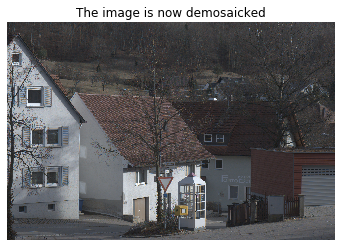

In [0]:
def demosaic(m):
    r = m[0::2, 0::2]
    g = np.clip(m[0::2, 1::2]//2 + m[1::2, 0::2]//2,
                0, 2 ** 16 - 1)
    b = m[1::2, 1::2]
    return np.dstack([r, g, b])

mosaic *= 2**2        # expand to 16bit for demosaicing
img = demosaic(mosaic)          # displayable rgb image
img_visualize = np.float32(img) / 2**16
plt.imshow(img_visualize**(1/2.2))
plt.axis('off')
plt.title('The image is now demosaicked')

Step 4: Denoising (Alternative)

In [0]:
#Alternative 1
#from scipy import ndimage
#img = ndimage.median_filter(img, size=3)

In [0]:
#Alternative 2
#pip install bm3d
#import bm3d
#denoised_image = bm3d.bm3d(image_noisy + 0.5, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING


Step 4: Color Space Conversion 

Text(0.5, 1.0, 'The image is now in linear sRGB color space')

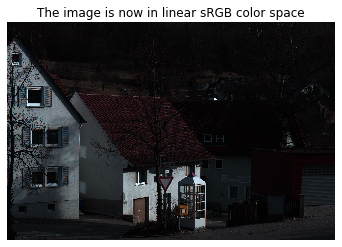

In [0]:
cam2xyz = raw.rgb_xyz_matrix[0:3, :]
xyz2cam = np.linalg.inv(cam2xyz)
srgb2xyz = np.array([[0.4124564,0.3575761,0.1804375],[0.2126729,0.7151522,0.0721750],[0.0193339,0.1191920,0.9503041]])

#print(srgb2xyz)

srgb2cam = xyz2cam * srgb2xyz

row_sums = srgb2cam.sum(axis=1)
new_matrix = srgb2cam / row_sums[:, np.newaxis]

cam2srgb = np.linalg.inv(new_matrix) #raw.rgb_xyz_matrix[0:3, :]
#print(cam2srgb)
cam2srgb = np.round(cam2srgb*255).astype(np.int16)
img = img // 2**8        # reduce dynamic range to 8bpp      
shape = img.shape
#print(shape)
pixels = img.reshape(-1, 3).T     # 3xN array of pixels
pixels = cam2srgb.dot(pixels)//255
#print(pixels.shape)
img = pixels.T.reshape(shape)
img = np.clip(img, 0, 255).astype(np.uint8)
plt.imshow(img)
plt.axis('off')
plt.title('The image is now in linear sRGB color space')

Step 5: Gamma and Tone Curve Application

Text(0.5, 1.0, 'The image is applied gamma curve')

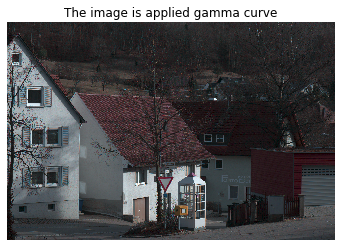

In [0]:
#gamma = 2.4
gamma = 1.8
#uncomment below to see the effect of different gamma 
#gamma = 2.2
gcurve = [(i / 255) ** (1 / gamma) * 255 for i in range(256)]
gcurve = np.array(gcurve, dtype=np.uint8)

img = gcurve[img]  # apply gamma as LUT
plt.imshow(img)
plt.axis('off')
plt.title('The image is applied gamma curve')

Text(0.5, 1.0, 'The image is applied tone curve')

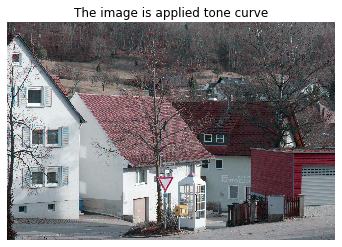

In [0]:
# below is a standard S-Shaped tone curve. We'll apply it as a LUT
tcurve = [0,0.00078,0.0016,0.00242,0.00314,0.00385,0.0046,0.00539,0.00623,0.00712,0.00806,0.00906,0.01012,0.01122,0.01238,0.01359,0.01485,0.01616,0.01751,0.0189,0.02033,0.0218,0.02331,0.02485,0.02643,0.02804,0.02967,0.03134,0.03303,0.03475,0.03648,0.03824,0.04002,0.04181,0.04362,0.04545,0.0473,0.04916,0.05103,0.05292,0.05483,0.05675,0.05868,0.06063,0.06259,0.06457,0.06655,0.06856,0.07057,0.07259,0.07463,0.07668,0.07874,0.08081,0.0829,0.08499,0.0871,0.08921,0.09134,0.09348,0.09563,0.09779,0.09996,0.10214,0.10433,0.10652,0.10873,0.11095,0.11318,0.11541,0.11766,0.11991,0.12218,0.12445,0.12673,0.12902,0.13132,0.13363,0.13595,0.13827,0.14061,0.14295,0.1453,0.14765,0.15002,0.15239,0.15477,0.15716,0.15956,0.16197,0.16438,0.1668,0.16923,0.17166,0.1741,0.17655,0.17901,0.18148,0.18395,0.18643,0.18891,0.19141,0.19391,0.19641,0.19893,0.20145,0.20398,0.20651,0.20905,0.2116,0.21416,0.21672,0.21929,0.22185,0.2244,0.22696,0.2295,0.23204,0.23458,0.23711,0.23963,0.24215,0.24466,0.24717,0.24967,0.25216,0.25465,0.25713,0.25961,0.26208,0.26454,0.267,0.26945,0.27189,0.27433,0.27676,0.27918,0.2816,0.28401,0.28641,0.28881,0.2912,0.29358,0.29596,0.29833,0.30069,0.30305,0.3054,0.30774,0.31008,0.31241,0.31473,0.31704,0.31935,0.32165,0.32395,0.32623,0.32851,0.33079,0.33305,0.33531,0.33756,0.33981,0.34205,0.34428,0.3465,0.34872,0.35093,0.35313,0.35532,0.35751,0.35969,0.36187,0.36404,0.3662,0.36835,0.3705,0.37264,0.37477,0.37689,0.37901,0.38112,0.38323,0.38533,0.38742,0.3895,0.39158,0.39365,0.39571,0.39777,0.39982,0.40186,0.40389,0.40592,0.40794,0.40996,0.41197,0.41397,0.41596,0.41795,0.41993,0.42191,0.42388,0.42584,0.42779,0.42974,0.43168,0.43362,0.43554,0.43747,0.43938,0.44129,0.44319,0.44509,0.44698,0.44886,0.45073,0.4526,0.45447,0.45632,0.45817,0.46002,0.46186,0.46369,0.46551,0.46733,0.46914,0.47095,0.47275,0.47454,0.47633,0.47811,0.47989,0.48166,0.48342,0.48518,0.48693,0.48867,0.49041,0.49214,0.49387,0.49559,0.4973,0.49901,0.50072,0.50241,0.5041,0.50579,0.50747,0.50914,0.51081,0.51247,0.51413,0.51578,0.51742,0.51906,0.52069,0.52232,0.52394,0.52556,0.52717,0.52878,0.53038,0.53197,0.53356,0.53514,0.53672,0.53829,0.53986,0.54142,0.54297,0.54452,0.54607,0.54761,0.54914,0.55067,0.5522,0.55371,0.55523,0.55673,0.55824,0.55973,0.56123,0.56271,0.5642,0.56567,0.56715,0.56861,0.57007,0.57153,0.57298,0.57443,0.57587,0.57731,0.57874,0.58017,0.58159,0.58301,0.58443,0.58583,0.58724,0.58864,0.59003,0.59142,0.59281,0.59419,0.59556,0.59694,0.5983,0.59966,0.60102,0.60238,0.60373,0.60507,0.60641,0.60775,0.60908,0.6104,0.61173,0.61305,0.61436,0.61567,0.61698,0.61828,0.61957,0.62087,0.62216,0.62344,0.62472,0.626,0.62727,0.62854,0.6298,0.63106,0.63232,0.63357,0.63482,0.63606,0.6373,0.63854,0.63977,0.641,0.64222,0.64344,0.64466,0.64587,0.64708,0.64829,0.64949,0.65069,0.65188,0.65307,0.65426,0.65544,0.65662,0.65779,0.65897,0.66013,0.6613,0.66246,0.66362,0.66477,0.66592,0.66707,0.66821,0.66935,0.67048,0.67162,0.67275,0.67387,0.67499,0.67611,0.67723,0.67834,0.67945,0.68055,0.68165,0.68275,0.68385,0.68494,0.68603,0.68711,0.68819,0.68927,0.69035,0.69142,0.69249,0.69355,0.69461,0.69567,0.69673,0.69778,0.69883,0.69988,0.70092,0.70196,0.703,0.70403,0.70506,0.70609,0.70711,0.70813,0.70915,0.71017,0.71118,0.71219,0.71319,0.7142,0.7152,0.7162,0.71719,0.71818,0.71917,0.72016,0.72114,0.72212,0.72309,0.72407,0.72504,0.72601,0.72697,0.72794,0.7289,0.72985,0.73081,0.73176,0.73271,0.73365,0.7346,0.73554,0.73647,0.73741,0.73834,0.73927,0.7402,0.74112,0.74204,0.74296,0.74388,0.74479,0.7457,0.74661,0.74751,0.74842,0.74932,0.75021,0.75111,0.752,0.75289,0.75378,0.75466,0.75555,0.75643,0.7573,0.75818,0.75905,0.75992,0.76079,0.76165,0.76251,0.76337,0.76423,0.76508,0.76594,0.76679,0.76763,0.76848,0.76932,0.77016,0.771,0.77183,0.77267,0.7735,0.77432,0.77515,0.77597,0.7768,0.77761,0.77843,0.77924,0.78006,0.78087,0.78167,0.78248,0.78328,0.78408,0.78488,0.78568,0.78647,0.78726,0.78805,0.78884,0.78962,0.7904,0.79118,0.79196,0.79274,0.79351,0.79428,0.79505,0.79582,0.79658,0.79735,0.79811,0.79887,0.79962,0.80038,0.80113,0.80188,0.80263,0.80337,0.80412,0.80486,0.8056,0.80634,0.80707,0.8078,0.80854,0.80926,0.80999,0.81072,0.81144,0.81216,0.81288,0.8136,0.81431,0.81503,0.81574,0.81645,0.81715,0.81786,0.81856,0.81926,0.81996,0.82066,0.82135,0.82205,0.82274,0.82343,0.82412,0.8248,0.82549,0.82617,0.82685,0.82753,0.8282,0.82888,0.82955,0.83022,0.83089,0.83155,0.83222,0.83288,0.83354,0.8342,0.83486,0.83552,0.83617,0.83682,0.83747,0.83812,0.83877,0.83941,0.84005,0.84069,0.84133,0.84197,0.84261,0.84324,0.84387,0.8445,0.84513,0.84576,0.84639,0.84701,0.84763,0.84825,0.84887,0.84949,0.8501,0.85071,0.85132,0.85193,0.85254,0.85315,0.85375,0.85436,0.85496,0.85556,0.85615,0.85675,0.85735,0.85794,0.85853,0.85912,0.85971,0.86029,0.86088,0.86146,0.86204,0.86262,0.8632,0.86378,0.86435,0.86493,0.8655,0.86607,0.86664,0.8672,0.86777,0.86833,0.86889,0.86945,0.87001,0.87057,0.87113,0.87168,0.87223,0.87278,0.87333,0.87388,0.87443,0.87497,0.87552,0.87606,0.8766,0.87714,0.87768,0.87821,0.87875,0.87928,0.87981,0.88034,0.88087,0.8814,0.88192,0.88244,0.88297,0.88349,0.88401,0.88453,0.88504,0.88556,0.88607,0.88658,0.88709,0.8876,0.88811,0.88862,0.88912,0.88963,0.89013,0.89063,0.89113,0.89163,0.89212,0.89262,0.89311,0.8936,0.89409,0.89458,0.89507,0.89556,0.89604,0.89653,0.89701,0.89749,0.89797,0.89845,0.89892,0.8994,0.89987,0.90035,0.90082,0.90129,0.90176,0.90222,0.90269,0.90316,0.90362,0.90408,0.90454,0.905,0.90546,0.90592,0.90637,0.90683,0.90728,0.90773,0.90818,0.90863,0.90908,0.90952,0.90997,0.91041,0.91085,0.9113,0.91173,0.91217,0.91261,0.91305,0.91348,0.91392,0.91435,0.91478,0.91521,0.91564,0.91606,0.91649,0.91691,0.91734,0.91776,0.91818,0.9186,0.91902,0.91944,0.91985,0.92027,0.92068,0.92109,0.9215,0.92191,0.92232,0.92273,0.92314,0.92354,0.92395,0.92435,0.92475,0.92515,0.92555,0.92595,0.92634,0.92674,0.92713,0.92753,0.92792,0.92831,0.9287,0.92909,0.92947,0.92986,0.93025,0.93063,0.93101,0.93139,0.93177,0.93215,0.93253,0.93291,0.93328,0.93366,0.93403,0.9344,0.93478,0.93515,0.93551,0.93588,0.93625,0.93661,0.93698,0.93734,0.9377,0.93807,0.93843,0.93878,0.93914,0.9395,0.93986,0.94021,0.94056,0.94092,0.94127,0.94162,0.94197,0.94231,0.94266,0.94301,0.94335,0.94369,0.94404,0.94438,0.94472,0.94506,0.9454,0.94573,0.94607,0.94641,0.94674,0.94707,0.9474,0.94774,0.94807,0.94839,0.94872,0.94905,0.94937,0.9497,0.95002,0.95035,0.95067,0.95099,0.95131,0.95163,0.95194,0.95226,0.95257,0.95289,0.9532,0.95351,0.95383,0.95414,0.95445,0.95475,0.95506,0.95537,0.95567,0.95598,0.95628,0.95658,0.95688,0.95718,0.95748,0.95778,0.95808,0.95838,0.95867,0.95897,0.95926,0.95955,0.95984,0.96013,0.96042,0.96071,0.961,0.96129,0.96157,0.96186,0.96214,0.96242,0.96271,0.96299,0.96327,0.96355,0.96382,0.9641,0.96438,0.96465,0.96493,0.9652,0.96547,0.96574,0.96602,0.96629,0.96655,0.96682,0.96709,0.96735,0.96762,0.96788,0.96815,0.96841,0.96867,0.96893,0.96919,0.96945,0.96971,0.96996,0.97022,0.97047,0.97073,0.97098,0.97123,0.97149,0.97174,0.97199,0.97223,0.97248,0.97273,0.97297,0.97322,0.97346,0.97371,0.97395,0.97419,0.97443,0.97467,0.97491,0.97515,0.97539,0.97562,0.97586,0.97609,0.97633,0.97656,0.97679,0.97702,0.97725,0.97748,0.97771,0.97794,0.97817,0.97839,0.97862,0.97884,0.97907,0.97929,0.97951,0.97973,0.97995,0.98017,0.98039,0.98061,0.98082,0.98104,0.98125,0.98147,0.98168,0.98189,0.98211,0.98232,0.98253,0.98274,0.98295,0.98315,0.98336,0.98357,0.98377,0.98398,0.98418,0.98438,0.98458,0.98478,0.98498,0.98518,0.98538,0.98558,0.98578,0.98597,0.98617,0.98636,0.98656,0.98675,0.98694,0.98714,0.98733,0.98752,0.98771,0.98789,0.98808,0.98827,0.98845,0.98864,0.98882,0.98901,0.98919,0.98937,0.98955,0.98973,0.98991,0.99009,0.99027,0.99045,0.99063,0.9908,0.99098,0.99115,0.99133,0.9915,0.99167,0.99184,0.99201,0.99218,0.99235,0.99252,0.99269,0.99285,0.99302,0.99319,0.99335,0.99351,0.99368,0.99384,0.994,0.99416,0.99432,0.99448,0.99464,0.9948,0.99495,0.99511,0.99527,0.99542,0.99558,0.99573,0.99588,0.99603,0.99619,0.99634,0.99649,0.99664,0.99678,0.99693,0.99708,0.99722,0.99737,0.99751,0.99766,0.9978,0.99794,0.99809,0.99823,0.99837,0.99851,0.99865,0.99879,0.99892,0.99906,0.9992,0.99933,0.99947,0.9996,0.99974,0.99987,1]
tcurve = np.array(tcurve, dtype=np.float32)
tcurve = tcurve[::4]
tcurve *= 255.0; 
tcurve = np.array(tcurve, dtype=np.uint8)

img = tcurve[img]  # apply tone curve as LUT
plt.imshow(img)
plt.axis('off')
plt.title('The image is applied tone curve')

Text(0.5, 0.98, 'The gamma and the tone curve')

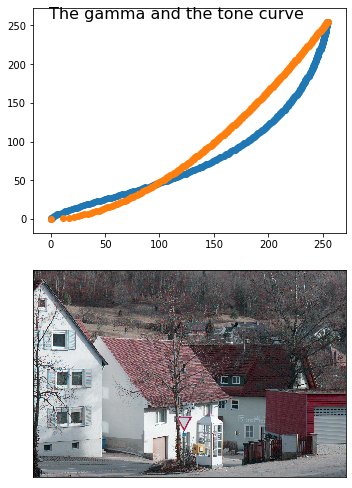

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 7))
axes[0].scatter(tcurve,np.linspace(0, 255, tcurve.size))
axes[0].scatter(gcurve,np.linspace(0, 255, gcurve.size))

axes[1].imshow(img)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
fig.tight_layout()
fig.suptitle('The gamma and the tone curve', fontsize=16)

Step 6: Save the image 

In [0]:
PIL.Image.fromarray(img).save('/content/drive/My Drive/image.tiff')

Step 7: Close the file

In [0]:
raw.close()